In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import ELPH_dyn

import narrom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# trajectories = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')
trajectories = narrom.utils.load_trajectories(filename='../runs_n_kmax=80.npz')


# trajectories = trajectories[::10]

for k in range(len(trajectories)):
    trajectories[k] = trajectories[k].T

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 80


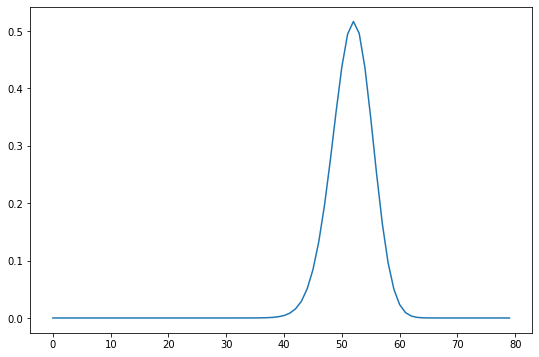

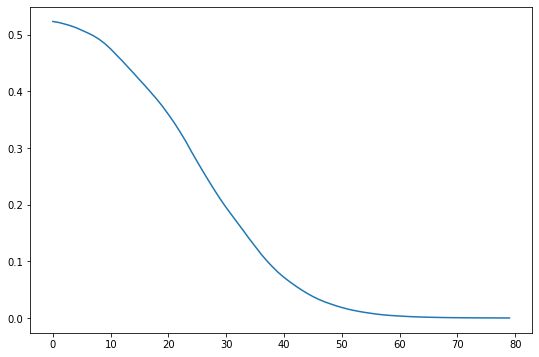

In [3]:
plt.plot(trajectories[1][0])
plt.show()

plt.plot(trajectories[1][-1])
plt.show()

In [150]:
def fermi(E,mu=1,T=1):
    return 1./(np.exp((E-mu)/(ELPH_dyn.kB*T)) + 1)

1000


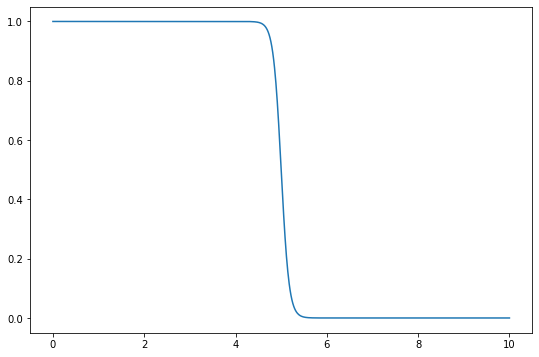

In [54]:
x = np.linspace(0,10,1000)

plt.plot(x,fermi(x,mu=5,T=1000))
plt.show()

In [192]:
#// Numerische Berechnung von chem-Pot und Temperatur der Verteilungen aus tatsächlicher Dichte

MAXERROR = 5E-12

STEP_LIMIT = 2000  #// maximale Anzahl an Schritten für eine Berechnung
dmu = 0.5E-3        #// differentieller Schritt zur Berechnung der Ableitungen d/dmu,d/dT
dT = 1
mstep_max = 0.05  #// maximale Schrittweite der Iterationen
Tstep_max = 25

dk = 4. / 80.


# // berechnet chem Pot. (eV) und Temperatur der Fermiverteilung
# // aus vorgegebener Ladungsträgerdichte + Gesamtenergie, Ausgabe in *mu, *temp
# // en_Bulk/QW/QD sind entweder Elektonen- oder Loch-Energien (werden durch Aufruf der jeweiligen calc_fermi_CP_e/h-Funktion gesetzt)
def calc_fermi_mu_T(state, disp, DOS, get_k, mu_start, T_start, FERMI_DEBUG = False):
    
    dens = 0.
    en = 0.
    
    for i in range(state.size):
        k = get_k(dk,i)
        #Gesamtdichte und -energie aufsummieren
        f = DOS(k,dk) * state[i]
        dens += f   
        en += f * disp(k)
        
#     print(dens,en)
    
    
    m=mu_start
    T=T_start;

    m2 = m;
    T2 = T;
#     steps = 0;
    d = 0
    d_dmu = 0
    d_dT = 0
    dDdmu = 0
    dDdT = 0;
    E = 0
    E_dmu = 0
    E_dT = 0
    dEdmu = 0
    dEdT = 0;
    f=0
    mstep=0
    Tstep=0

    Jacobi_Det = 0;
    deltaD = 0
    deltaE = 0
    for steps in range(STEP_LIMIT):
        d = d_dmu = d_dT = 0
        E = E_dmu = E_dT = 0
        #// resultierende Dichte + Energie aus Fermifunktion aufsummieren
        #// m2 = m+delta_m,
        #// Berechnung der Jacobi-Matrix von (Dichte, Energie) nach (mu, T)
        m2 = m+dmu
        T2 = T+dT

        for i in range(state.size):
                       
            #calc k
            k = get_k(dk,i)
            #Gesamtdichte und -energie aufsummieren
            f = DOS(k,dk) * fermi(disp(k), m, T)
            d += f   
            E += f * disp(k)

            #Werte bei mu = mu+dmu
            f = DOS(k,dk) * fermi(disp(k), m2, T)
            d_dmu += f        
            E_dmu += f * disp(k)

            #Werte bei T = T+dT
            f = DOS(k,dk) * fermi(disp(k), m, T2)
            d_dT += f        
            E_dT += f * disp(k)
            
        # Genau genug -> fertig
        error = np.maximum( np.abs(d/dens-1.), np.abs(E/en-1.));
        if ( error <= MAXERROR ): 
#             print('error: ', error)
            break

        #//Jacobi-Matrix-Elemente berechnen
        dDdmu = (d_dmu-d)/dmu
        dEdmu = (E_dmu-E)/dmu
        dDdT = (d_dT-d)/dT
        dEdT = (E_dT-E)/dT
        Jacobi_Det = dDdT*dEdmu-dDdmu*dEdT
        if (Jacobi_Det == 0):
            print("calc_fermi_CC_eh: Jacobi_Det wird null!!!")
            print("     d=",d,"  mu=",m,"  E=",E,"  T=",T)
            break
        
        #// Berechne neues mu,T durch Lösung von A.(deltaMu, deltaT) = (deltaD, deltaE). => Invertierung der Jacobimatrix gibt dmu,dT
        deltaD = dens-d
        deltaE = en-E
        mstep = (deltaE*dDdT-deltaD*dEdT)/Jacobi_Det
        Tstep = (deltaD*dEdmu-deltaE*dDdmu)/Jacobi_Det

        if(mstep < -mstep_max):
            mstep = -mstep_max
        elif (mstep > mstep_max):
            mstep = mstep_max;
        if(Tstep < -Tstep_max):
            Tstep = -Tstep_max
        elif (Tstep > Tstep_max):
            Tstep = Tstep_max

        m += mstep;
        T += Tstep;
    
        if FERMI_DEBUG:
            print("calc_fermi_CC_eh: dens=",d,", en=",en)
            print("calc_fermi_CC_eh: mu=",m,", T=",T," nach ",steps," Schritten")

    if (steps == STEP_LIMIT-1):
        print("calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!")
        print("calc_fermi_CC_eh: mu_start=",mu_start,",T_start=",T_start)
        print("calc_fermi_CC_eh: dens=",dens,", en=",en)
        print("calc_fermi_CC_eh: d=",d,", E=",E)
        print("calc_fermi_CC_eh: mu=",m,", T=",T)
        print("calc_fermi_CC_eh: error=",error," nach ",steps," Schritten")

            
    return m,T,steps


In [177]:

disp = ELPH_dyn.electron_dispersion

DOS = ELPH_dyn.electron_DOS

get_k = ELPH_dyn.get_k

print(dk)
print(4./80)
print(ELPH_dyn.get_k(dk,1))

0.05
0.05
0.1


state density:  0.09410235535723391
0.010469956249962538 1419.3882513934982 20
qfermi density:  0.09410235535722503


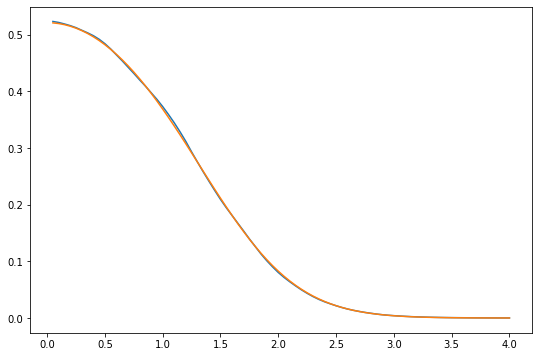

In [202]:
state = trajectories[1][-1]

print('state density: ', ELPH_dyn.get_density_from_state(state,dk))

mu,Temp,steps = calc_fermi_mu_T(state, disp, DOS, get_k, 0.1, 1000, False)

print(mu, Temp, steps)

ks = get_k(dk,np.arange(state.size))
ens = disp(ks)

qfermi = fermi(ens,mu,Temp)

print('qfermi density: ', ELPH_dyn.get_density_from_state(qfermi,dk))

plt.plot(ks,state)
plt.plot(ks,qfermi)
plt.show()